In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms, datasets
import pandas as pd
from PIL import ImageOps, Image
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

/Users/emmanuellyngberg/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/emmanuellyngberg/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b)
  Referenced from: '/Users/emmanuellyngberg/anaconda3/lib/python3.11/site-packages/torchvision/image.so'
  Expected in: '/Users/emmanuellyngberg/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [232]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


In [2]:
# the transformations we will apply
transform = transforms.Compose([
    # transforms.CenterCrop((400,400)),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

# Function to apply contrast enhancement using PIL's histogram equalization
def enhance_contrast(image_tensor):
    pil_image = transforms.ToPILImage()(image_tensor).convert("L")  # Convert tensor to PIL grayscale image
    enhanced_image = ImageOps.equalize(pil_image)  # Apply histogram equalization
    enhanced_tensor = transforms.ToTensor()(enhanced_image)  # Convert PIL image to tensor
    return enhanced_tensor

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.enhance = enhance_contrast
        self.labels = self.generate_labels()

    def generate_labels(self):
        labels = []
        for class_name in os.listdir(self.data_dir):
            class_path = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_path):
                for image_name in os.listdir(class_path):
                    labels.append({'image_path': os.path.join(class_path, image_name), 'label': class_name})
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.labels[idx]['image_path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            # image = self.enhance(image)
        
        label = self.labels[idx]['label']
        return {'image': image, 'label': label}

In [4]:
def imshow(tensor, title=None):
    # Convert tensor to NumPy array
    image = tensor.numpy().transpose((1, 2, 0))
    
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip values to be in the valid range for imshow with RGB data
    image = np.clip(image, 0, 1)
    
    # Display the image
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [5]:
# Set directory
data_directory = "/Users/emmanuellyngberg/Documents/brain_tumor/tumor_testing"
normal_data_directory = "/Users/emmanuellyngberg/Documents/brain_tumor/normal_training"

# data_directory = "/Users/emmanuellyngberg/Documents/chest_xray/all_data/"
# normal_data_directory = "/Users/emmanuellyngberg/Documents/chest_xray/train/"


In [7]:
# Create a dataset instance
dataset = CustomDataset(data_dir=data_directory, transform=transform)
normal_dataset = CustomDataset(data_dir=normal_data_directory, transform=transform)


# Define batch size for DataLoader
batch_size = 32

#Make subsets for testing 
subset_size_test = int(0.5 * len(dataset)) 
subset_size_train = int(0.5 * len(normal_dataset))

subset_indices_test = torch.randperm(len(dataset)).tolist()[:subset_size_test]
# subset_indices_test = np.arange(3799, 4499)
test_subset =  Subset(dataset, subset_indices_test)

subset_indices_train = torch.randperm(len(normal_dataset)).tolist()[:subset_size_train]
train_subset = Subset(normal_dataset, subset_indices_train)


print("Smaller training dataset length: {}".format(len(train_subset)))
print("Smaller testing dataset length: {}".format(len(test_subset)))

train_subset_dataloader = DataLoader(train_subset, batch_size=4, shuffle=True)
test_subset_dataloader = DataLoader(test_subset, batch_size=4, shuffle=False)


print("Full training dataset length: {}".format(len(normal_dataset)))
print("Full testing dataset length: {}".format(len(dataset)))
# Create DataLoader instances for training and testing
train_dataloader = DataLoader(normal_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print("Smaller dataloader test size: {}".format(len(test_subset_dataloader)))
print("Smaller dataloader train size: {}".format(len(train_subset_dataloader)))



Smaller training dataset length: 797
Smaller testing dataset length: 805
Full training dataset length: 1595
Full testing dataset length: 1611
Smaller dataloader test size: 202
Smaller dataloader train size: 200


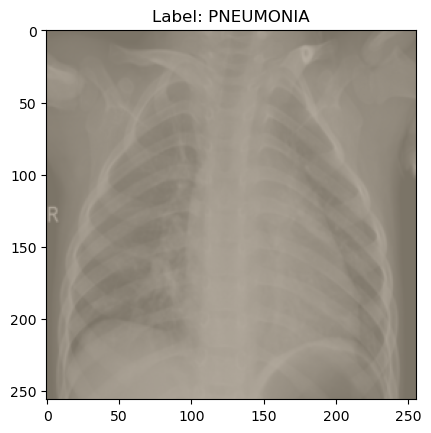

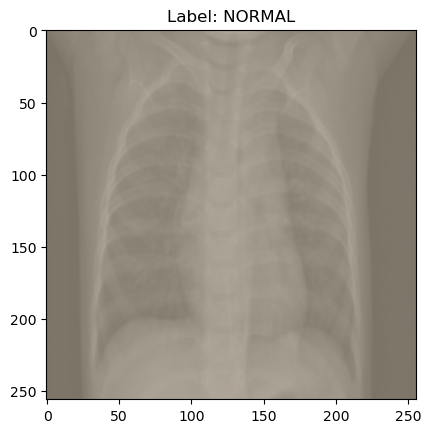

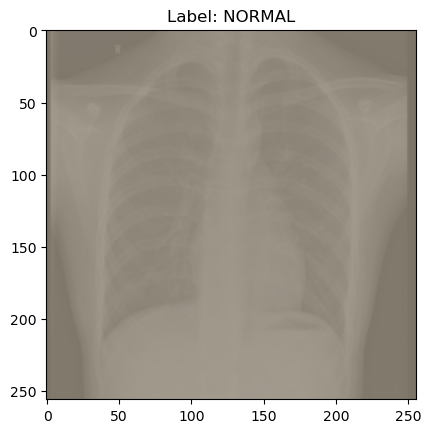

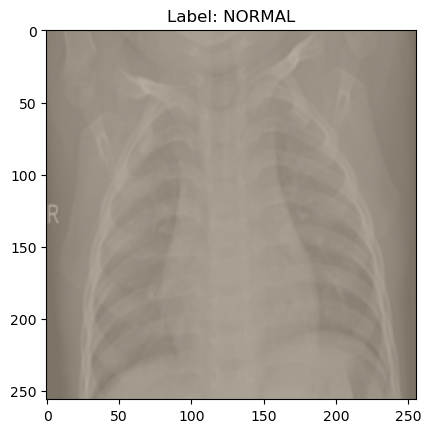

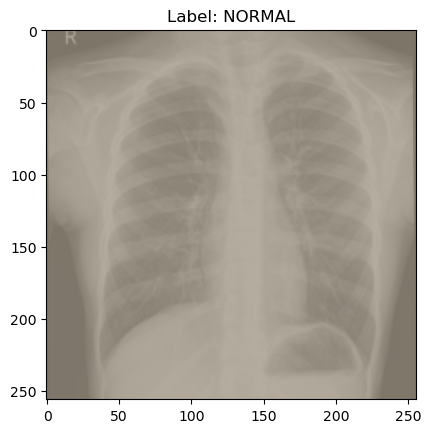

In [251]:
num_images_to_display = 5

# Create a random subset of the dataset
random_subset_indices = np.random.choice(len(test_subset), num_images_to_display, replace=False)
random_subset = Subset(test_subset, random_subset_indices)

# Display the random subset of images
for sample in random_subset:
    image = sample['image']
    label = sample['label']
    imshow(image, title=f'Label: {label}')
# Keep the plot window open
plt.show()

In [252]:
# Initialize a Counter to count the occurrences of each class
class_counts = Counter()

# Iterate through the DataLoader to count class occurrences
for batch in test_subset_dataloader:
    labels = batch['label']
    class_counts.update(labels)

# Display the class balances
total_samples = sum(class_counts.values())
print(total_samples)
for class_label, count in class_counts.items():
    class_balance = count / total_samples
    print(f"Class {class_label}: {count} samples, Class Balance: {class_balance:.2%}")

700
Class PNEUMONIA: 466 samples, Class Balance: 66.57%
Class NORMAL: 234 samples, Class Balance: 33.43%


In [253]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),  # (256, 256)
            act_fn,
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(out_channels, 2 * out_channels, 3, padding=1, stride=2),  # (128, 128)
            act_fn,
            nn.Conv2d(2 * out_channels, 2 * out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(2 * out_channels, 4 * out_channels, 3, padding=1, stride=2),  # (64, 64)
            act_fn,
            nn.Conv2d(4 * out_channels, 4 * out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(4 * out_channels, 8 * out_channels, 3, padding=1, stride=2),  # (32, 32)
            act_fn,
            nn.Conv2d(8 * out_channels, 8 * out_channels, 3, padding=1),
            act_fn,
            nn.Flatten(),
            nn.Linear(8 * out_channels * 32 * 32, latent_dim),
            act_fn
        )

    def forward(self, x):
        output = self.net(x)
        return output


class Decoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
        super().__init__()

        self.out_channels = out_channels

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 8 * out_channels * 32 * 32),
            act_fn
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(8 * out_channels, 8 * out_channels, 3, padding=1),  # (32, 32)
            act_fn,
            nn.ConvTranspose2d(8 * out_channels, 4 * out_channels, 3, padding=1, stride=2, output_padding=1),  # (64, 64)
            act_fn,
            nn.ConvTranspose2d(4 * out_channels, 4 * out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(4 * out_channels, 2 * out_channels, 3, padding=1, stride=2, output_padding=1),  # (128, 128)
            act_fn,
            nn.ConvTranspose2d(2 * out_channels, 2 * out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(2 * out_channels, out_channels, 3, padding=1, stride=2, output_padding=1),  # (256, 256)
            act_fn,
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
        )

    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 8 * self.out_channels, 32, 32)
        output = self.conv(output)
        return output


class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.encoder.to(device)

        self.decoder = decoder
        self.decoder.to(device)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [254]:
autoencoder = Autoencoder(Encoder(), Decoder())

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

Epoch [1/10], Loss: 0.0861
Epoch [2/10], Loss: 0.0550
Epoch [3/10], Loss: 0.0539
Epoch [4/10], Loss: 0.0540
Epoch [5/10], Loss: 0.0540
Epoch [6/10], Loss: 0.0532
Epoch [7/10], Loss: 0.0529
Epoch [8/10], Loss: 0.0504
Epoch [9/10], Loss: 0.0493
Epoch [10/10], Loss: 0.0496


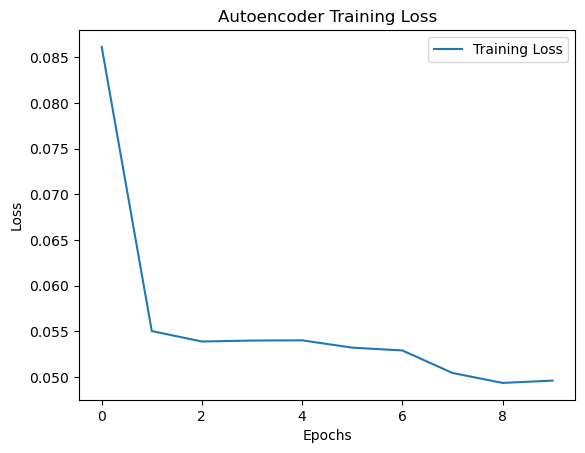

In [255]:
# Train the autoencoder
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_subset_dataloader:
        images = batch['image']
        # Forward pass
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
    
        # Backward pass and optimization
        optimizer.zero_grad()

        loss.backward()
    
        optimizer.step()
        print("Forward and Backward pass and optimization complete")
        epoch_loss += loss.item()


    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_subset_dataloader)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

# Plot the loss distribution
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.show()


In [256]:
# save_path = "/Users/emmanuellyngberg/Documents/brain_encoder_1"
save_path = "/Users/emmanuellyngberg/Documents/chest_encoder_1"
torch.save(autoencoder.state_dict(), save_path)

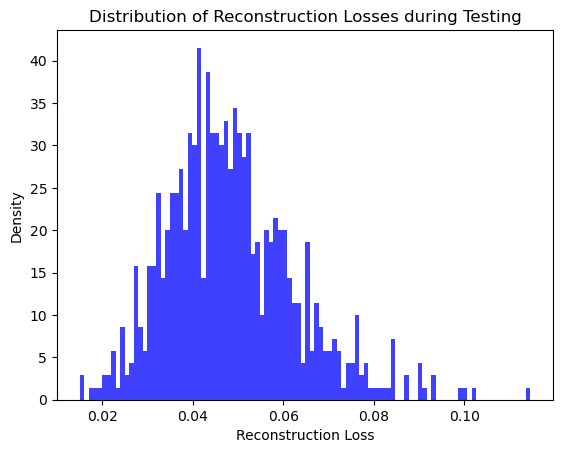

In [268]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the autoencoder and load the trained weights
autoencoder = Autoencoder(Encoder(), Decoder())
autoencoder.load_state_dict(torch.load(save_path))
autoencoder.to(device)
autoencoder.eval()  # Set the model to evaluation mode


# Set anomaly threshold
threshold = 0.040


# Initialize lists to store losses for each batch
all_losses = []
true_labels = []
predicted_labels = []

# Iterate through the test DataLoader to get reconstruction losses
with torch.no_grad():
    for batch in test_subset_dataloader:
        images = batch['image'].to(device)
        labels = batch['label']
        # Forward pass
        outputs = autoencoder(images)
        true_labels.extend(labels)
        # Calculate reconstruction loss (MSE loss) for each sample in the batch
        batch_losses = torch.nn.functional.mse_loss(outputs, images, reduction='none')
        mean_batch_losses = torch.mean(batch_losses, dim=(1, 2))
        mean_loss_per_image = torch.mean(mean_batch_losses, dim=1) 
        mean_loss_per_image = mean_loss_per_image.cpu().numpy()  # Convert losses to a numpy array

        # Append losses for this batch to all_losses
        all_losses.extend(mean_loss_per_image)
        # Predict labels for the current batch based on the threshold
        for mean_loss in mean_loss_per_image:
            is_anomaly = mean_loss > threshold
            predicted_labels.append("PNEUMONIA" if is_anomaly else "NORMAL")
            
        

# Plot the distribution of all_losses as a histogram
plt.hist(all_losses, bins=100, density=True, alpha=0.75, color='blue')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Distribution of Reconstruction Losses during Testing')
plt.show()

In [269]:
true_labels_np = np.array(true_labels)
all_losses_np = np.array(all_losses)

# Get unique labels from the true labels
unique_labels = np.unique(true_labels_np)
print(unique_labels)
# Dictionary to store mean and standard deviation of losses per label
label_stats = {}

for label in unique_labels:
    # Select losses corresponding to the current label
    label_losses = all_losses_np[true_labels_np == label]
    
    # Compute mean and standard deviation of losses for the current label
    mean_loss = np.mean(label_losses)
    std_dev_loss = np.std(label_losses)
    
    # Store the results in the dictionary
    label_stats[label] = {
        'mean_loss': mean_loss,
        'std_dev_loss': std_dev_loss
    }

# Print or use label_stats as needed
for label, stats in label_stats.items():
    print(f"Label {label}:")
    print(f"  Mean Loss: {stats['mean_loss']}")
    print(f"  Standard Deviation of Loss: {stats['std_dev_loss']}")
    print()

['NORMAL' 'PNEUMONIA']
Label NORMAL:
  Mean Loss: 0.05094822496175766
  Standard Deviation of Loss: 0.011627539992332458

Label PNEUMONIA:
  Mean Loss: 0.04715757817029953
  Standard Deviation of Loss: 0.01536375842988491



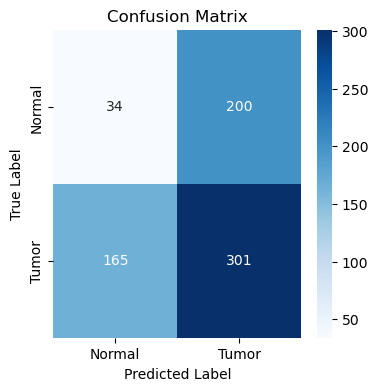

In [270]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [271]:

# Calculate the accuracy from the confusion matrix
true_positives, true_negatives = np.diag(conf_matrix)
total_samples = np.sum(conf_matrix)

accuracy = (true_positives + true_negatives) / total_samples

print(f'Accuracy: {accuracy:.2%}')

Accuracy: 47.86%
